In [274]:
import scipy.io
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.stats import skew
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [317]:
#load training data
training_data = scipy.io.loadmat("train_data.mat")
training_data_images = training_data["data"]
training_data_labels = np.array(training_data["label"][0])

#load testing data
testing_data = scipy.io.loadmat("test_data.mat")
testing_data_images = testing_data["data"]
testing_data_labels = np.array(testing_data["label"][0])

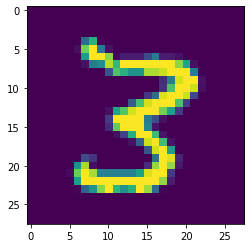

In [318]:
#sample image
imgplot = plt.imshow(training_data_images[0])

In [319]:
#flatten images to form a 784 dim array
training_data_images = np.reshape(training_data_images, (len(training_data_images), 784))
l, b = np.shape(training_data_images)
testing_data_images = np.reshape(testing_data_images, (len(testing_data_images), 784))

In [320]:
#calculate Skewness Method to check the skewness values
skewness = []
for i in range(l):
    skewness.append(skew(training_data_images[i], axis = 0))
    
skewness_Test = []
for i in range(len(testing_data_images)):
    skewness_Test.append(skew(testing_data_images[i], axis = 0))

In [321]:
#calculate Skewness written function
s = []
for img in training_data_images:
    mean_img = np.mean(img)
    sd_img = np.std(img)
    img = (img-mean_img)**3
    s.append(np.mean(img)/sd_img**3)

    
#calculate skewness for Testing data
s_t = []
for img in testing_data_images:
    mean_img = np.mean(img)
    sd_img = np.std(img)
    img = (img-mean_img)**3
    s_t.append(np.mean(img)/sd_img**3)

#Calculate values for normalization 
M1 = np.mean(s)
S1 = np.std(s)

#normalized feature
s = (s-M1)/S1
s_t = (s_t-M1)/S1

In [322]:
#Task 4
#Case 1: T=150; Case 2: T=200
T = 150

In [323]:
#calculate brightness
def calculate_intensity(img, threshold):
    bright_pixels = 0
    for x in range(784):
        if img[x]>threshold:
            bright_pixels+=1
    return bright_pixels/(748-bright_pixels)

In [324]:
#calculate brightness for images
bright_ratio=[]
for img in training_data_images:
    bright_ratio.append(calculate_intensity(img, T))

#calculate brightness for testing images
bright_ratio_t=[]
for img in testing_data_images:
    bright_ratio_t.append(calculate_intensity(img, T))
    
#Calculate values for normalization 
M2 = np.mean(bright_ratio)
S2 = np.std(bright_ratio)

#normalized feature
bright_ratio = (bright_ratio-M2)/S2
bright_ratio_t = (bright_ratio_t-M2)/S2

       skewness  brightness  label
0     -0.312630   -0.053448      3
1      0.965460   -0.846922      3
2      0.516517   -0.814982      3
3      0.297382   -0.490324      3
4      1.906885   -1.436391      3
...         ...         ...    ...
11543  1.135147   -0.942180      7
11544  0.841204   -0.846922      7
11545  0.754219   -0.942180      7
11546  0.232806   -0.324323      7
11547 -0.268342    0.119234      7

[11548 rows x 3 columns]
      skewness  brightness  label
0    -1.267680    1.290567      3
1    -0.520284    0.294593      3
2    -1.277741    1.484635      3
3    -2.033069    3.114399      3
4    -0.208492   -0.223514      3
...        ...         ...    ...
2881 -1.193159    1.252130      7
2882  0.229900   -0.223514      7
2883  1.042951   -0.973746      7
2884 -0.128389    0.119234      7
2885  1.605895   -1.253740      7

[2886 rows x 3 columns]


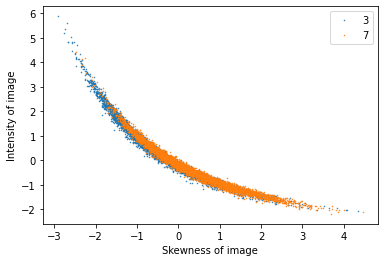

In [325]:
df = pd.DataFrame()
df['skewness'] = s
df['brightness'] = bright_ratio
df['label'] = training_data_labels
print(df)

groups = df.groupby('label')
for name, group in groups:
    plt.plot(group.skewness, group.brightness, marker='o', linestyle='', markersize=0.5, label=name)

plt.xlabel("Skewness of image")
plt.ylabel("Intensity of image")
plt.legend()

normalized_features = []
for i in range(len(s)):
    normalized_features.append([s[i],bright_ratio[i]])

#dataframe and normalized feaeture for testing images
df_t = pd.DataFrame()
df_t['skewness'] = s_t
df_t['brightness'] = bright_ratio_t
df_t['label'] = testing_data_labels
print(df_t)

normalized_features_t = []
for i in range(len(s_t)):
    normalized_features_t.append([s_t[i],bright_ratio_t[i]])

In [326]:
training_three = []
training_seven = []
for x in range(len(normalized_features)):
    if training_data_labels[x]==3:
        training_three.append(normalized_features[x])
    else:
        training_seven.append(normalized_features[x])

In [327]:
mean3 = np.mean(training_three,axis=0)
mean7 = np.mean(training_seven,axis=0)
cov3 = np.matmul((training_three-mean3).T,(training_three-mean3))/len(training_three)
cov7 = np.matmul((training_seven-mean7).T,(training_seven-mean7))/len(training_seven)

#distributions for training images
pdf3 = multivariate_normal.pdf(normalized_features, mean=mean3, cov=cov3)
pdf7 = multivariate_normal.pdf(normalized_features, mean=mean7, cov=cov7)

#distributions for testing images
pdf3_t = multivariate_normal.pdf(normalized_features_t, mean=mean3, cov=cov3)
pdf7_t = multivariate_normal.pdf(normalized_features_t, mean=mean7, cov=cov7)

In [328]:
#Task 3
#Case1: p(3) = 0.5, p(7) = 0.5; p(3) = 0.3, p(7) = 0.7 
p3 = 0.5
p7 = 0.5

In [329]:
#Estimation on Training Data
likelihood3 = pdf3*p3
likelihood7 = pdf7*p7

result = []
for i in range(len(normalized_features)):
    if likelihood3[i]>likelihood7[i]:
        result.append(3)
    else:
        result.append(7)
df['likelihood3'] = likelihood3
df['likelihood7'] = likelihood7
df['result'] = result
correctPredictions = 0
for i in range(len(df)):
    if df['label'][i] == df['result'][i]:
        correctPredictions+=1

ErrorRate = (1-(correctPredictions/len(normalized_features)))*100
print(ErrorRate)

34.47350190509179


In [330]:
#Estimation on Testing Data
#Case1: p(3) = 0.5, p(7) = 0.5; p(3) = 0.3, p(7) = 0.7 
likelihood3 = pdf3_t*p3
likelihood7 = pdf7_t*p7

result = []
for i in range(len(normalized_features_t)):
    if likelihood3[i]>likelihood7[i]:
        result.append(3)
    else:
        result.append(7)
df_t['likelihood3'] = likelihood3
df_t['likelihood7'] = likelihood7
df_t['result'] = result

correctPredictions = 0
for i in range(len(df_t)):
    if df_t['label'][i] == df_t['result'][i]:
        correctPredictions+=1
ErrorRate = (1-(correctPredictions/len(normalized_features_t)))*100
print(ErrorRate)

33.61053361053361
